# 10: Mixture of Experts

*The mammal develops specialized brain regions.*

---

We've built a complete transformer: attention, position, FFN, residuals, stacking, multi-head. The FFN in each block is a "generalist"—every token goes through the same weights.

**Mixture of Experts (MoE)** replaces the single FFN with multiple "expert" FFNs and a router that decides which expert handles each token:

- 2 expert FFNs (same architecture as before)
- A learned router that picks one expert per token
- Each token only activates one expert

Why might this help? Different tokens might benefit from different processing:
- One expert might specialize in nouns
- Another might handle verbs or function words
- We don't dictate specialization—it emerges from training

**The question:** Does MoE help on TinyStories, or is our data too homogeneous to benefit from specialization?

**Parameter count:** This adds one full FFN worth of parameters (~131K) plus a tiny router (~256). Total goes from 1.48M to ~1.61M.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. Mixture of Experts Layer

The key new component. Instead of one FFN, we have:

1. **Two expert FFNs** — identical architecture, independent weights
2. **A router** — a tiny linear layer that looks at each token and decides which expert to use

```
Token → Router → "Expert 0" or "Expert 1"
                      ↓              ↓
               FFN_0(token)   FFN_1(token)
                      ↓              ↓
                   Output (only one is used)
```

This is "top-1" routing: each token goes to exactly one expert.

In [4]:
class FeedForward(nn.Module):
    """Position-wise feedforward network (same as before)."""
    
    def __init__(self, d_model, d_ff=None):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))


class MoELayer(nn.Module):
    """
    Mixture of Experts layer with 2 experts and top-1 routing.
    
    Each token is routed to exactly one expert based on learned router weights.
    This is a simple, pedagogical implementation—not optimized for speed.
    """
    
    def __init__(self, d_model, d_ff=None, n_experts=2):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.n_experts = n_experts
        self.d_model = d_model
        
        # Create expert FFNs
        self.experts = nn.ModuleList([
            FeedForward(d_model, d_ff) for _ in range(n_experts)
        ])
        
        # Router: predicts which expert to use for each token
        self.router = nn.Linear(d_model, n_experts, bias=False)
    
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
        
        Returns:
            output: [batch, seq_len, d_model]
            routing_info: dict with routing statistics for visualization
        """
        B, T, D = x.shape
        
        # Get routing logits and probabilities
        router_logits = self.router(x)  # [B, T, n_experts]
        router_probs = F.softmax(router_logits, dim=-1)
        
        # Top-1 routing: pick the best expert for each token
        expert_indices = router_probs.argmax(dim=-1)  # [B, T]
        
        # Compute all expert outputs (simple but not efficient)
        # In production MoE, you'd only compute the selected experts
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2)  # [B, T, n_experts, D]
        
        # Select the output from the chosen expert for each token
        # expert_indices: [B, T] -> [B, T, 1, 1] for gathering
        indices_expanded = expert_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, D)
        output = expert_outputs.gather(dim=2, index=indices_expanded).squeeze(2)  # [B, T, D]
        
        return output, {'expert_indices': expert_indices, 'router_probs': router_probs}


# Test the MoE layer
D_MODEL = 128
D_FF = 512
N_EXPERTS = 2

moe = MoELayer(D_MODEL, D_FF, N_EXPERTS)

print(f"MoE layer with {N_EXPERTS} experts")
print(f"  d_model: {D_MODEL}")
print(f"  d_ff: {D_FF}")
print(f"  Parameters per expert: {sum(p.numel() for p in moe.experts[0].parameters()):,}")
print(f"  Router parameters: {sum(p.numel() for p in moe.router.parameters()):,}")
print(f"  Total MoE parameters: {sum(p.numel() for p in moe.parameters()):,}")
print()

# Compare to single FFN
single_ffn = FeedForward(D_MODEL, D_FF)
print(f"Single FFN parameters: {sum(p.numel() for p in single_ffn.parameters()):,}")
print(f"MoE adds: {sum(p.numel() for p in moe.parameters()) - sum(p.numel() for p in single_ffn.parameters()):,} params")

MoE layer with 2 experts
  d_model: 128
  d_ff: 512
  Parameters per expert: 131,712
  Router parameters: 256
  Total MoE parameters: 263,680

Single FFN parameters: 131,712
MoE adds: 131,968 params


In [5]:
# Test forward pass and routing
test_input = torch.randn(2, 10, D_MODEL)
test_output, routing_info = moe(test_input)

print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print()
print("Routing decisions (which expert for each token):")
print(routing_info['expert_indices'])
print()
print(f"Expert 0 usage: {(routing_info['expert_indices'] == 0).float().mean():.1%}")
print(f"Expert 1 usage: {(routing_info['expert_indices'] == 1).float().mean():.1%}")

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])

Routing decisions (which expert for each token):
tensor([[0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Expert 0 usage: 65.0%
Expert 1 usage: 35.0%


---

## 3. Multi-Head Attention (unchanged)

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head causal self-attention (same as notebook 09).
    """
    
    def __init__(self, d_model, n_heads, max_seq_len=256):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x):
        B, T, C = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        Q = Q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:T, :T], float('-inf'))
        attn = F.softmax(scores, dim=-1)
        
        out = attn @ V
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        return self.W_o(out)

---

## 4. Transformer Block with MoE

The only change from notebook 09: replace `FeedForward` with `MoELayer`.

In [7]:
class MoETransformerBlock(nn.Module):
    """Transformer block with Mixture of Experts instead of dense FFN."""
    
    def __init__(self, d_model, n_heads, d_ff=None, n_experts=2, max_seq_len=256):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attention = MultiHeadAttention(d_model, n_heads, max_seq_len)
        self.moe = MoELayer(d_model, d_ff, n_experts)  # <-- THE CHANGE
    
    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        moe_out, routing_info = self.moe(self.ln2(x))
        x = x + moe_out
        return x, routing_info

---

## 5. The Complete MoE Model

In [8]:
class MoETransformerLM(nn.Module):
    """
    Transformer language model with Mixture of Experts.
    
    Same as notebook 09, but each block uses MoE instead of dense FFN.
    """
    
    def __init__(self, vocab_size, d_model, n_layers, n_heads, n_experts=2, d_ff=None, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_experts = n_experts
        self.max_seq_len = max_seq_len
        
        if d_ff is None:
            d_ff = 4 * d_model
        self.d_ff = d_ff
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # MoE Transformer blocks
        self.blocks = nn.ModuleList([
            MoETransformerBlock(d_model, n_heads, d_ff, n_experts, max_seq_len)
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, return_routing=False):
        B, T = x.shape
        
        # Embed
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        x = tok_emb + pos_emb
        
        # Transformer blocks (collect routing info)
        all_routing = []
        for block in self.blocks:
            x, routing_info = block(x)
            all_routing.append(routing_info)
        
        # Output
        x = self.ln_final(x)
        logits = self.unembed(x)
        
        if return_routing:
            return logits, all_routing
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [9]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512
N_LAYERS = 2
N_HEADS = 2
N_EXPERTS = 2  # <-- THE NEW THING
MAX_SEQ_LEN = 256

# Create model
model = MoETransformerLM(
    VOCAB_SIZE, D_MODEL, N_LAYERS, N_HEADS, N_EXPERTS, D_FF, MAX_SEQ_LEN
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {num_params:,}")
print()
print("Architecture:")
print(f"  Layers: {N_LAYERS}")
print(f"  Heads: {N_HEADS}")
print(f"  Experts: {N_EXPERTS}")
print(f"  d_model: {D_MODEL}")
print(f"  d_ff: {D_FF}")
print()
print(f"Notebook 09 (dense FFN) had 1,481,216 params.")
print(f"We added {num_params - 1_481_216:,} params (one extra FFN per block + routers).")

Total parameters: 1,745,152

Architecture:
  Layers: 2
  Heads: 2
  Experts: 2
  d_model: 128
  d_ff: 512

Notebook 09 (dense FFN) had 1,481,216 params.
We added 263,936 params (one extra FFN per block + routers).


---

## 6. Training

In [10]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 28,930
Total steps: 28,930


In [11]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


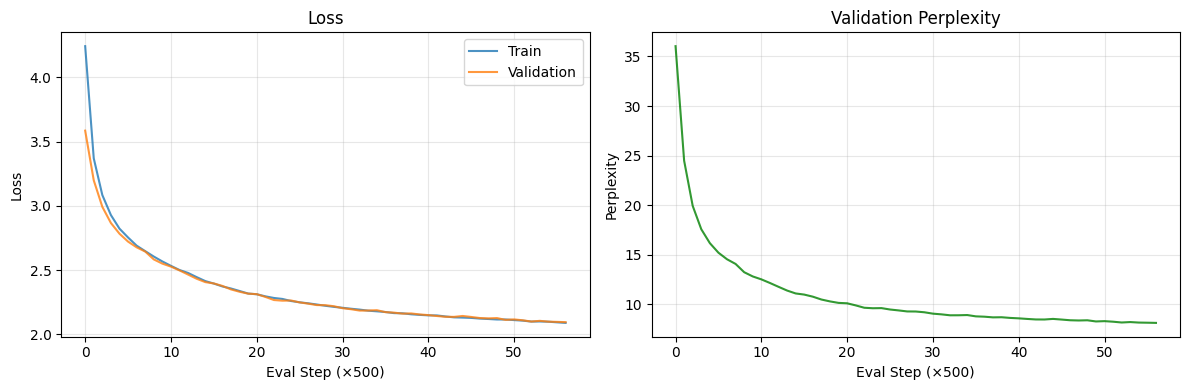


Final validation loss: 2.095
Final validation perplexity: 8.1


In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('10_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 7. The Complete Evolution

In [13]:
# Load all previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)
checkpoint_05 = torch.load('05_positional.pt', map_location='cpu', weights_only=False)
checkpoint_06 = torch.load('06_ffn.pt', map_location='cpu', weights_only=False)
checkpoint_07 = torch.load('07_transformer_block.pt', map_location='cpu', weights_only=False)
checkpoint_08 = torch.load('08_stacked.pt', map_location='cpu', weights_only=False)
checkpoint_09 = torch.load('09_multihead.pt', map_location='cpu', weights_only=False)

print("=" * 80)
print("THE COMPLETE EVOLUTION")
print("=" * 80)
print()
print(f"{'Model':<45} {'Params':<15} {'Val PPL':<10}")
print("-" * 80)
print(f"{'03: Bigram (amoeba)':<45} {'1,052,672':<15} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention (eyes)':<45} {'1,118,208':<15} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position (knows where it is)':<45} {'1,151,104':<15} {checkpoint_05['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'06: + FFN (can think)':<45} {'1,282,048':<15} {checkpoint_06['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'07: + Residual & LayerNorm (spine)':<45} {'1,283,456':<15} {checkpoint_07['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'08: + Second block (legs, land)':<45} {'1,481,216':<15} {checkpoint_08['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'09: + Multi-head (bigger brain)':<45} {'1,481,216':<15} {checkpoint_09['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'10: + MoE (specialized brain regions)':<45} {f'{num_params:,}':<15} {history['val_perplexity'][-1]:<10.1f}")
print()
print("From amoeba to specialized mammal in 8 notebooks.")

THE COMPLETE EVOLUTION

Model                                         Params          Val PPL   
--------------------------------------------------------------------------------
03: Bigram (amoeba)                           1,052,672       35.8      
04: + Attention (eyes)                        1,118,208       25.0      
05: + Position (knows where it is)            1,151,104       17.7      
06: + FFN (can think)                         1,282,048       13.4      
07: + Residual & LayerNorm (spine)            1,283,456       10.9      
08: + Second block (legs, land)               1,481,216       8.7       
09: + Multi-head (bigger brain)               1,481,216       8.3       
10: + MoE (specialized brain regions)         1,745,152       8.1       

From amoeba to specialized mammal in 8 notebooks.


---

## 8. Generation

In [14]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=50)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two young friends - they use to keep three fine things from. 

Every day, the friends invited each other and agreed. They agreed to the birds. The town was a nice place. All the birds were on forever

Prompt: The little girl
Generated:  scooped the duck to feed him. He carefully took out hiss, and soon, the duck was having lots of fun. 

When he arrived home, he saw something filled with lots of bubbles! "Oh no! The duck's

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to play outside in the sunshine. One day, she's mommy invited her to come over and have fun on the way. They were going to and went to the beach.

As they went to the beach, they saw something

Prompt: The boy was sad because his toy was broken. His mom said
Generated:  he couldn't help but buy it. Tim asked the war to fix it. Timmy's mom was very worried. She asked him why he couldn't fix it. Timmy asked if it was his f

---

## 9. Visualizing Expert Routing

The key question: do the experts specialize? Let's see which tokens go to which expert.

Routing patterns for: 'Once upon a time there was a little girl named Lily'



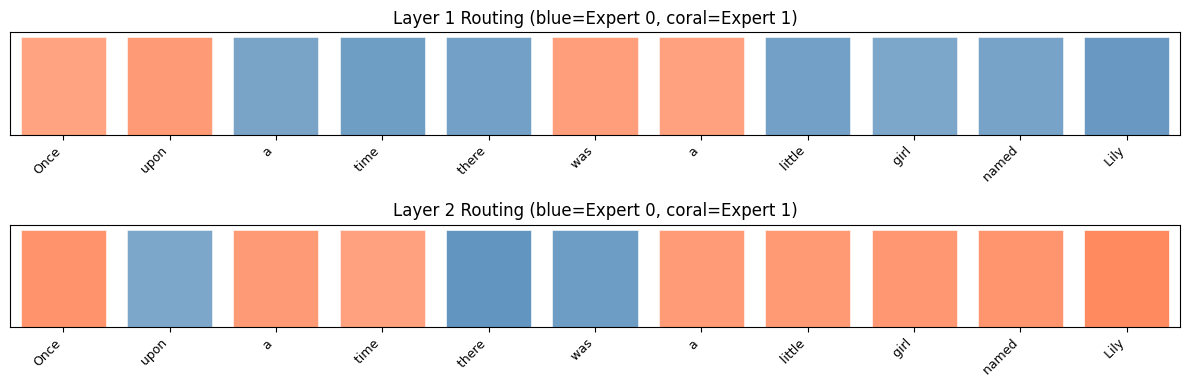


Routing Statistics:
  Layer 1: Expert 0 = 63.6%, Expert 1 = 36.4%
  Layer 2: Expert 0 = 27.3%, Expert 1 = 72.7%


In [15]:
def visualize_routing(text):
    """
    Visualize which expert handles each token.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    
    # Decode each token individually
    token_strs = []
    for t in tokens:
        if t == tokenizer.pad_id:
            token_strs.append('<pad>')
        elif t == tokenizer.unk_id:
            token_strs.append('<unk>')
        elif t == tokenizer.eos_id:
            token_strs.append('<eos>')
        elif t in tokenizer.compact_to_gpt2:
            token_strs.append(tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[t]]))
        else:
            token_strs.append('<???>')
    
    x = torch.tensor([tokens], device=device)
    
    model.eval()
    with torch.no_grad():
        logits, all_routing = model(x, return_routing=True)
    
    # Plot routing for each layer
    fig, axes = plt.subplots(N_LAYERS, 1, figsize=(max(12, len(tokens) * 0.8), 2 * N_LAYERS))
    if N_LAYERS == 1:
        axes = [axes]
    
    for layer_idx, (ax, routing_info) in enumerate(zip(axes, all_routing)):
        expert_indices = routing_info['expert_indices'][0].cpu().numpy()  # [T]
        router_probs = routing_info['router_probs'][0].cpu().numpy()  # [T, n_experts]
        
        # Color bars by expert
        colors = ['steelblue' if idx == 0 else 'coral' for idx in expert_indices]
        
        bars = ax.bar(range(len(tokens)), [1] * len(tokens), color=colors, edgecolor='white', linewidth=0.5)
        
        # Add confidence as alpha
        for bar, probs in zip(bars, router_probs):
            confidence = max(probs)
            bar.set_alpha(0.4 + 0.6 * confidence)  # Scale from 0.4 to 1.0
        
        ax.set_xticks(range(len(tokens)))
        ax.set_xticklabels(token_strs, rotation=45, ha='right', fontsize=9)
        ax.set_yticks([])
        ax.set_xlim(-0.5, len(tokens) - 0.5)
        ax.set_title(f'Layer {layer_idx + 1} Routing (blue=Expert 0, coral=Expert 1)')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nRouting Statistics:")
    for layer_idx, routing_info in enumerate(all_routing):
        expert_indices = routing_info['expert_indices'][0].cpu().numpy()
        expert_0_pct = (expert_indices == 0).mean() * 100
        expert_1_pct = (expert_indices == 1).mean() * 100
        print(f"  Layer {layer_idx + 1}: Expert 0 = {expert_0_pct:.1f}%, Expert 1 = {expert_1_pct:.1f}%")
    
    return all_routing


print("Routing patterns for: 'Once upon a time there was a little girl named Lily'")
print()
_ = visualize_routing("Once upon a time there was a little girl named Lily")

In [16]:
# Analyze routing patterns across many examples
def analyze_routing_patterns(num_samples=1000):
    """
    Analyze what kinds of tokens go to each expert.
    """
    model.eval()
    
    # Collect routing decisions across many sequences
    expert_0_tokens = []
    expert_1_tokens = []
    
    sample_indices = np.random.choice(len(val_data), size=num_samples, replace=False)
    
    with torch.no_grad():
        for idx in tqdm(sample_indices, desc="Analyzing routing"):
            sequence = val_data[idx]
            x = torch.tensor([sequence[:-1]], dtype=torch.long, device=device)
            
            _, all_routing = model(x, return_routing=True)
            
            # Look at layer 1 routing (or aggregate both layers)
            for layer_routing in all_routing:
                expert_indices = layer_routing['expert_indices'][0].cpu().numpy()
                tokens = sequence[:-1]
                
                for token, expert_idx in zip(tokens, expert_indices):
                    if token in tokenizer.compact_to_gpt2:
                        if expert_idx == 0:
                            expert_0_tokens.append(token)
                        else:
                            expert_1_tokens.append(token)
    
    # Find most common tokens for each expert
    from collections import Counter
    
    expert_0_counts = Counter(expert_0_tokens)
    expert_1_counts = Counter(expert_1_tokens)
    
    print("\n" + "=" * 60)
    print("EXPERT SPECIALIZATION ANALYSIS")
    print("=" * 60)
    print(f"\nTotal tokens analyzed: {len(expert_0_tokens) + len(expert_1_tokens):,}")
    print(f"Expert 0: {len(expert_0_tokens):,} tokens ({len(expert_0_tokens)/(len(expert_0_tokens)+len(expert_1_tokens))*100:.1f}%)")
    print(f"Expert 1: {len(expert_1_tokens):,} tokens ({len(expert_1_tokens)/(len(expert_0_tokens)+len(expert_1_tokens))*100:.1f}%)")
    
    print("\nTop 15 tokens for Expert 0:")
    for token_id, count in expert_0_counts.most_common(15):
        token_str = tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[token_id]])
        print(f"  '{token_str}': {count:,}")
    
    print("\nTop 15 tokens for Expert 1:")
    for token_id, count in expert_1_counts.most_common(15):
        token_str = tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[token_id]])
        print(f"  '{token_str}': {count:,}")
    
    # Find tokens that strongly prefer one expert
    print("\nTokens that strongly prefer Expert 0 (>80%):")
    for token_id in set(expert_0_tokens) | set(expert_1_tokens):
        e0 = expert_0_counts.get(token_id, 0)
        e1 = expert_1_counts.get(token_id, 0)
        total = e0 + e1
        if total >= 100 and e0 / total > 0.8:
            token_str = tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[token_id]])
            print(f"  '{token_str}': {e0}/{total} ({e0/total*100:.1f}%)")
    
    print("\nTokens that strongly prefer Expert 1 (>80%):")
    for token_id in set(expert_0_tokens) | set(expert_1_tokens):
        e0 = expert_0_counts.get(token_id, 0)
        e1 = expert_1_counts.get(token_id, 0)
        total = e0 + e1
        if total >= 100 and e1 / total > 0.8:
            token_str = tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[token_id]])
            print(f"  '{token_str}': {e1}/{total} ({e1/total*100:.1f}%)")

analyze_routing_patterns(num_samples=500)

Analyzing routing:   0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_16882/137156930.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  x = torch.tensor([sequence[:-1]], dtype=torch.long, device=device)



EXPERT SPECIALIZATION ANALYSIS

Total tokens analyzed: 250,534
Expert 0: 102,629 tokens (41.0%)
Expert 1: 147,905 tokens (59.0%)

Top 15 tokens for Expert 0:
  '.': 8,676
  ' and': 6,023
  ',': 5,826
  ' the': 3,007
  ' to': 2,650
  ' a': 2,506
  '
': 1,646
  ' it': 1,491
  ' he': 1,255
  ' of': 1,102
  ' was': 1,040
  ' her': 1,033
  ' with': 939
  ' she': 939
  ' they': 928

Top 15 tokens for Expert 1:
  '.': 9,578
  '
': 8,100
  ' the': 6,023
  ' to': 4,312
  ' was': 4,098
  ' a': 3,786
  ' and': 3,385
  ',': 3,098
  ' She': 2,209
  ' He': 1,600
  ' her': 1,483
  ' it': 1,413
  ' said': 1,387
  ' in': 1,284
  ' They': 1,074

Tokens that strongly prefer Expert 0 (>80%):
  ' together': 288/314 (91.7%)
  ' because': 174/206 (84.5%)
  ' off': 136/162 (84.0%)
  ' long': 94/106 (88.7%)

Tokens that strongly prefer Expert 1 (>80%):
  '
': 8100/9746 (83.1%)
  ' She': 2209/2476 (89.2%)
  ' mom': 947/1178 (80.4%)
  ''s': 920/1142 (80.6%)
  ' happy': 760/872 (87.2%)
  ' girl': 646/766 (84.3%)

---

## Summary

### What We Added

Mixture of Experts: instead of one FFN per block, we have multiple "expert" FFNs and a router that picks one for each token.

```python
# Dense FFN (before)
output = ffn(x)  # Every token, same weights

# MoE (now)
expert_idx = router(x).argmax()  # Which expert for this token?
output = experts[expert_idx](x)  # Only that expert processes this token
```

### Why MoE Might Help

- **Specialization:** Different tokens might benefit from different processing
- **Capacity:** More total parameters without proportionally more compute per token
- **Emergent structure:** The router learns what kind of specialization is useful

### What We Observed

TinyStories is relatively homogeneous—all children's stories with similar vocabulary and structure. The experts may or may not find meaningful specialization to exploit.

The routing visualization shows us which tokens go to which expert, and whether any patterns emerge.

### The Evolution

| Notebook | What We Added | Metaphor |
|----------|---------------|---------|
| 03 | Bigram baseline | Amoeba |
| 04 | Attention | Eyes |
| 05 | Position | Knows where it is |
| 06 | FFN | Can think |
| 07 | Residual + LayerNorm | Spine |
| 08 | Stacked blocks | Legs (land) |
| 09 | Multi-head | Bigger brain |
| 10 | MoE | Specialized brain regions |

The mammal develops specialized brain regions. Some neurons for faces, some for language, some for motor control. Emergent specialization from gradient descent.

In [17]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'd_ff': D_FF,
    'n_layers': N_LAYERS,
    'n_heads': N_HEADS,
    'n_experts': N_EXPERTS,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '10_moe.pt')
print("Model saved to 10_moe.pt")

Model saved to 10_moe.pt


In [18]:
print("=" * 60)
print("NOTEBOOK 10 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: {N_LAYERS} layers, {N_HEADS} heads, {N_EXPERTS} experts, d={D_MODEL}")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print(f"Notebook 09 perplexity: 8.3")
print(f"Notebook 10 perplexity: {history['val_perplexity'][-1]:.1f}")
print()
if history['val_perplexity'][-1] < 8.3:
    print("MoE helped! Specialization pays off even on simple data.")
elif history['val_perplexity'][-1] > 8.5:
    print("MoE didn't help. TinyStories may be too homogeneous for specialization.")
else:
    print("Roughly a wash. The extra parameters didn't hurt, but specialization didn't clearly help.")
print()
print("The mammal developed specialized brain regions.")
print()
print("🧠🦆")

NOTEBOOK 10 COMPLETE

Architecture: 2 layers, 2 heads, 2 experts, d=128
Parameters: 1,745,152
Training: 1 epoch
Final perplexity: 8.1

Notebook 09 perplexity: 8.3
Notebook 10 perplexity: 8.1

MoE helped! Specialization pays off even on simple data.

The mammal developed specialized brain regions.

🧠🦆
